# Imports and installations

In [1]:
!pip show gym

Name: gym
Version: 0.25.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.ml/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /usr/local/lib/python3.8/dist-packages
Requires: cloudpickle, gym-notices, importlib-metadata, numpy
Required-by: dopamine-rl


In [2]:
!pip install gym-super-mario-bros --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 KB 963.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.6 MB/s eta 0:00:00


In [3]:
!pip install gdown==4.5.4 --no-cache-dir --quiet

In [4]:
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.nn import init
from torchvision import transforms as T
from torch.nn import functional as F
from torch.distributions.categorical import Categorical
import threading

import matplotlib.pyplot as plt
import time, random, datetime, os, copy
from collections import deque

import gym
import gym_super_mario_bros
from gym.spaces import Box
from gym.wrappers import FrameStack
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace
from IPython.display import HTML
from base64 import b64encode
import cv2

import warnings 
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# For reproducibility
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

['/content/agents/agent_with_curiosity.pt', '/content/agents/agent.pt']

# Tests on the environment

SuperMarioBros-[world]-[stage]-v[version]

- [world] is a number in {1, 2, 3, 4, 5, 6, 7, 8} indicating the world
- [stage] is a number in {1, 2, 3, 4} indicating the stage within a world
- [version] is a number in {0, 1, 2, 3} specifying the ROM mode to use
    - 0: standard ROM
    - 1: downsampled ROM
    - 2: pixel ROM
    - 3: rectangle ROM

From https://pypi.org/project/gym-super-mario-bros/

In [22]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

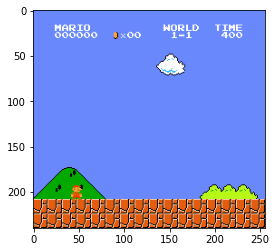

(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79}


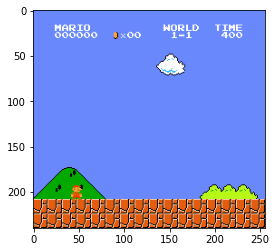

(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 84}


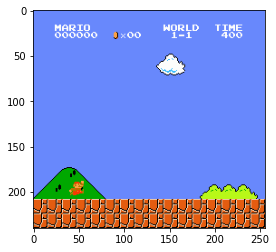

(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 89}


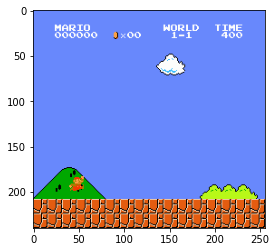

(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 93}


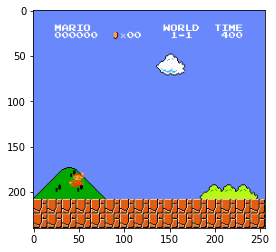

(240, 256, 3)
0.0
False
{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 98}


In [23]:
done = True
for step in range(5):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    plt.imshow(state)
    plt.show()
    print(state.shape)
    print(reward)
    print(done)
    print(info)

env.close()

In [24]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

SIMPLE_MOVEMENT **ACTIONS**
0. NOOP: stop
1. right: go right
2. right, A: jump and go right
3. right, B: go right faster
4. right, A, B: jump and go right faster
5. A: jump
6. left: go left

In [25]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
done = True
for step in range(500):
    if done:
        print("reset")
        state = env.reset()
    action = 4 #env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done:
      print("done")

reset
done
reset
done
reset
done
reset
done
reset


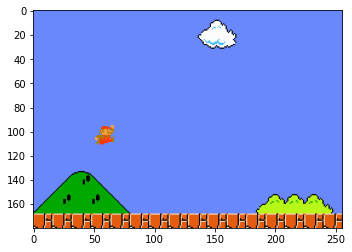

In [26]:
plt.imshow(state[40: 220, :]) #cut the image since the bottom and the top aren't relevant to take decisions
plt.show()

# Environment Wrappers

We have defined a few wrappers for the environment:

1.   `SkipFrame` allows to accumulate the reward of $n_{\text{skip}}$ frames of the game in order to avoid considering consecutive frames that may be too similar.
2.   `CutGrayScaleObservation` allows to cut every frame of the game like we have shown in the previous section, putting also the number of channels as first dimension like PyTorch requires. Moreover, it transforms the frame into a black and white version.
3.   `ResizeObservation` resizes the frame into a $[1,84,84]$ tensor.
4.   `CustomReward`gives the agent a bonus if it reaches the flag or a penalty if it dies.

We have also used `FrameStack` from gym's official wrappers. It's very useful because it allows to call the reset and the step methods of the environment without the need of handling a deque data structure. In particular, as it is showed in the section "Examples", `FrameStack` with parameter 4 would behave like a deque containing the last 4 frames if we weren't using `SkipFrame`.



In [7]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, n_skip):
        super().__init__(env)
        self.n_skip = n_skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self.n_skip):
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return state, total_reward, done, info


class CutGrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def cut_and_permute(self, state):
        state = np.transpose(state[40: 220, :], (2, 0, 1))
        state = torch.tensor(state.copy(), dtype=torch.float32)
        return state

    def observation(self, state):
        state = self.cut_and_permute(state)
        transform = T.Grayscale()
        state = transform(state)
        return state


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, state):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 200)]
        )
        state = transforms(state).squeeze(0)
        return state


class CustomReward(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        if done:
            if info['flag_get']:
                reward += 1000.0
            else:
                reward -= 50.0
        return state, reward, done, info

# Examples

In [27]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, n_skip = 4) #forse per l'evaluation è meglio toglierlo
env = CustomReward(env)

In [29]:
done = True
for step in range(5):
    if done:
        state = env.reset()
    action = 4 #env.action_space.sample()
    state, reward, done, info = env.step(action)

print(info)

# plt.imshow(state)
# plt.show()

{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 399, 'world': 1, 'x_pos': 53, 'y_pos': 139}


In [30]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = SkipFrame(env, n_skip = 4) #forse per l'evaluation è meglio toglierlo
env = CustomReward(env)
env = CutGrayScaleObservation(env)
env = ResizeObservation(env, shape = 84)
env = FrameStack(env, num_stack = 4)

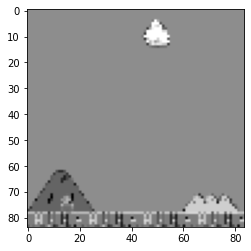

(4, 84, 84)
[tensor(True), tensor(False), tensor(False)]


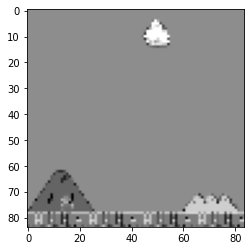

(4, 84, 84)
[tensor(True), tensor(False), tensor(False)]


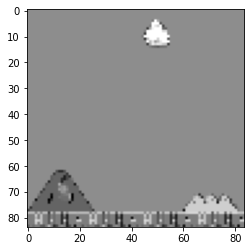

(4, 84, 84)
[tensor(True), tensor(False), tensor(False)]


In [33]:
done = True
first_state = state
for step in range(3):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    plt.imshow(state[3].data.numpy(), cmap = "gray")
    plt.show()
    print(state.shape)
    print([(first_state[i+1] == state[i]).all() for i in range(3)]) #without SkipFrame, FrameStack is equal to a deque 


# Intrinsic curiosity model

The **Intrinsic curiosity module** (from [1]) is a curiosity generator that at each time instant $t$ outputs a signal $r_t^i$ computed in a self-supervised fashion in the following way: 

1.   The agent in state $s_t$ samples an action $a_t$ from its current policy $\pi_t$ and ends up it the state $s_{t+1}$. The ICM takes in input the two subsequent states and the action executed by the agent and encodes the states into their feature representations $\phi(s_{t})$ and $\phi(s_{t+1})$.
2.   The **Forward model** of the ICM is trained to predict the features $\hat\phi(s_{t+1})$ of $s_{t+1}$ starting from the features $\phi(s_{t})$ of $s_t$ and the action $a_t$. The loss $L_{\text{forward}}$ for this model is the mean squared error between the real features and the predicted ones.
3.   The **Inverse dynamics** model of the ICM instead uses the real features from both states to predict the action $\hat a_t$ that was executed by the agent to get from $s_t$ to $s_{t+1}$. The loss $L_{\text{inverse_dynamics}}$ for this model is the cross entropy because it's a classification problem over the action space.
4.   The signal $r_t^i$ is computed as the mean squared error between $\phi(s_{t+1})$ and $\hat\phi(s_{t+1})$ multiplied by a factor $\eta$.
5.   The policy is trained to optimize the sum of this result with the extrinsic reward $r_t^e$. The ICM is trained to minimize $(1 - \beta)\cdot L_{\text{inverse_dynamics}}+ \beta*L_{\text{forward}}$, where $\beta ∈ [0,1]$ is an hyperparameter.










**Note:** The vanilla agent doesn't use any additional weight initialization. In order to test it like we did comment the `for` loop in the constructor of the class `FeatureExtractor`.

In [8]:
class Flatten(nn.Module):
  def forward(self, state):
    return state.reshape(-1, 16*21*21)

class FeatureExtractor(nn.Module):
  def __init__(self, hidden_size):
    super(FeatureExtractor, self).__init__()
    
    self.cnn = nn.Sequential(
        nn.Conv2d(4, 16, 7, padding = 3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16, 16, 7, padding = 3),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 16, 5, padding = 2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2),
        Flatten(),
        nn.Linear(16*21*21, hidden_size)
    )

    # Weights initialization
    #Comment it to test the vanilla agent
    """
    for p in self.modules():
      if isinstance(p, nn.Conv2d):
        init.orthogonal_(p.weight, np.sqrt(2))
        if p.bias is not None:
            init.constant_(p.bias, 0)

      if isinstance(p, nn.Linear):
        init.orthogonal_(p.weight, np.sqrt(2))
        if p.bias is not None:
            nn.init.constant_(p.bias, 0)
    """
  
  def forward(self, states):
    return self.cnn(states)

# Intrinsic curiosity module
class ICM(nn.Module): 
  def __init__(self, hidden_size, n_actions, cnn, device):
    super(ICM, self).__init__()
    self.hidden_size = hidden_size
    self.n_actions = n_actions
    self.device = device

    self.state_features_extractor = cnn
    
    self.inverse_dynamics_model = nn.Sequential(
        nn.Linear(2*hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )

    self.forward_model = nn.Sequential(
        nn.Linear(hidden_size + 1, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size)
    )

  def input_preprocessing(self, state, next_state, action):
    state = torch.FloatTensor(np.array([s.__array__() for s in state])).to(self.device)
    next_state = torch.FloatTensor(np.array([s.__array__() for s in next_state])).to(self.device)
    action = torch.tensor(action, dtype=torch.int64).to(self.device)
    return state, next_state, action

  def forward(self, state, next_state, action):
    state, next_state, action = self.input_preprocessing(state, next_state, action)
    state = self.state_features_extractor(state)
    next_state = self.state_features_extractor(next_state)

    predicted_action = self.inverse_dynamics_model(torch.cat((state, next_state), 1)) #logits pre softmax 
    predicted_next_state = self.forward_model(torch.cat((state, action.unsqueeze(1)), 1))

    return next_state, predicted_next_state, action, predicted_action


# Parallel advantage actor-critic 

The authors of the paper used the A3C algorithm (asynchronous advantage actor-critic) to train their agents and learn policies. This algorithm uses multiple agents in parallel with their own neural network parameters and a copy of the environment. This approach wasn’t suitable to run on our computers or on a Colab notebook because of the limited GPU performances.

We decided to use the **Parallel Advantage Actor-Critic** algorithm (PAA-C) from this paper [2] which uses a single agent but maintains the core idea of parallelism of the original paper. There are $k$ threads with their own environments and current states that execute actions sampled from the current policy during an $n$-step rollout. The results obtained by the threads are then aggregated and used to train the policy.


In [9]:
class ActorCritic(nn.Module):
  def __init__(self, hidden_size, n_actions, device):
    super(ActorCritic, self).__init__()
    self.hidden_size = hidden_size
    self.n_actions = n_actions
    self.device = device
  
    self.state_features_extractor = FeatureExtractor(hidden_size).to(self.device)

    self.actor = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )

    self.critic = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size // 2),
        nn.ReLU(),
        nn.Linear(hidden_size // 2, 1)
    )

    # Weights initialization
    for i in range(len(self.actor)):
      if type(self.actor[i]) == nn.Linear:
        init.orthogonal_(self.actor[i].weight, 0.01)
        self.actor[i].bias.data.zero_()

    for i in range(len(self.critic)):
      if type(self.critic[i]) == nn.Linear:
        init.orthogonal_(self.critic[i].weight, 0.01)
        self.critic[i].bias.data.zero_()
  
  def forward(self, state):
    state = torch.FloatTensor(np.array([s.__array__() for s in state])).to(self.device)
    state = self.state_features_extractor(state)
    
    policy = self.actor(state) # (logits pre softmax)
    value = self.critic(state) # V(state)
    return policy, value

  def act(self, states): # action that maximizes the reward (for evaluation)
    # 'unsqueeze' is used to have a batch of size 1
    states = torch.vstack([s for s in states]).unsqueeze(0).to(self.device)
    action_logits = self.actor(self.state_features_extractor(states))
    return action_logits.argmax(-1).cpu().item()

The class Agent can be used to train agents with or without ICM. In the second case the method `intrinsic_reward` would return an array of zeros so that the policy is maximizing only the sum of discounted extrinsic rewards.

The `sample_action` method returns an action sampled from the current policy. The policy is learning a categorical probability distributions over the actions.

The `train` method uses the training data produced by aggregating the results of the threads and implements advantage actor-critic with the actor loss modified like PPO (proximal policy optimization) would do: the new policy can deviate from the old one only of a small $\epsilon$.

In [10]:
class Agent:
  def __init__(
      self,
      n_actions,
      device,
      use_icm=True,
      epochs=10,
      batch_size=16,
      hidden_size=512,
      learning_rate=7e-5,
      epsilon_ppo=0.3,
      beta=0.2,
      eta=2,
    ):
    
    self.device = device
    self.use_icm = use_icm
    self.n_actions = n_actions
    self.epochs = epochs

    self.batch_size = batch_size
    self.hidden_size = hidden_size
    self.learning_rate = learning_rate

    self.epsilon_ppo = epsilon_ppo
    self.beta = beta
    self.eta = eta

    # Actor-Critic
    self.model = ActorCritic(hidden_size, self.n_actions, self.device).to(self.device)
    self.model_optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)

    # Curiosity
    if use_icm: 
      self.icm = ICM(hidden_size, self.n_actions, self.model.state_features_extractor, self.device).to(self.device)
      self.icm_optimizer = optim.Adam(self.icm.parameters(), lr = learning_rate)
    

  def intrinsic_reward(self, state, next_state, action):
    if not self.use_icm:
      return np.zeros_like(action)

    next_state_feats, pred_next_state_feats, _, _ = self.icm(state, next_state, action)

    # shape: [num_workers] Necessary if we have multiple workers
    intrinsic_reward = self.eta * F.mse_loss(pred_next_state_feats, next_state_feats, reduction='none').mean(-1) 
    
    return intrinsic_reward.data.cpu().numpy() 

  # Returns an action sampled from the policy in that state
  def sample_action(self, state): 
    policy, value = self.model(state)
    m = Categorical(F.softmax(policy, dim = -1))
    action = m.sample()
    return action.data.cpu().numpy(), value.data.cpu().numpy().squeeze(), policy.detach()

  def train(self, states, next_states, targets, actions, advs, old_policies):
    
    if self.use_icm:
      inverse_dyn_model_CE = nn.CrossEntropyLoss()
      forward_model_MSE = nn.MSELoss()

    advs = torch.FloatTensor(advs).to(self.device)
    targets = torch.FloatTensor(targets).to(self.device)
    
    with torch.no_grad():
      policy_old_list = torch.stack(old_policies).permute(1, 0, 2).contiguous().view(-1, self.n_actions).to(self.device)
      m_old = Categorical(F.softmax(policy_old_list, dim=-1))
      log_prob_old = m_old.log_prob(torch.tensor(actions, dtype=torch.float32, device=self.device))
    
    sample_range = np.arange(len(states))
    for i in range(self.epochs):
      np.random.shuffle(sample_range)
      for j in range(int(len(states) / self.batch_size)):
        idx = sample_range[j*self.batch_size : (j + 1)*self.batch_size]
        
        inverse_dynamics_loss, forward_loss = 0, 0

        if self.use_icm:
          nstate, pred_nstate, action, pred_action = self.icm(states[idx], next_states[idx], actions[idx])
          inverse_dynamics_loss = inverse_dyn_model_CE(pred_action, action)
          forward_loss = forward_model_MSE(pred_nstate, nstate)

        policy, value = self.model(states[idx])
        m = Categorical(F.softmax(policy, dim=-1))
        log_prob = m.log_prob(torch.tensor(actions[idx], dtype=torch.float32, device=self.device))


        # PPO policy update -> the new policy can go at most epsilon "far" from the old one
        ratio = torch.exp(log_prob - log_prob_old[idx])
        surrogate1 = ratio * advs[idx]
        surrogate2 = torch.clamp(ratio, 
                                 1.0 - self.epsilon_ppo, 
                                 1.0 + self.epsilon_ppo) * advs[idx]
        actor_loss = -torch.min(surrogate1, surrogate2).mean()
        
        # Value loss
        with torch.no_grad():
          value = value.squeeze()
          
        critic_loss = F.mse_loss(value, targets[idx])

        entropy = m.entropy().mean()

        self.model_optimizer.zero_grad()
        if self.use_icm:
          self.icm_optimizer.zero_grad()
        
        loss = 0.1 * (actor_loss + 0.5 * critic_loss - 0.001 * entropy) + \
              (1 - self.beta)*inverse_dynamics_loss + self.beta*forward_loss
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
        self.model_optimizer.step()
        
        if self.use_icm:
          torch.nn.utils.clip_grad_norm_(self.icm.parameters(), 0.5)
          self.icm_optimizer.step()

      # if i % 10 == 0 or i == self.epochs - 1:
      #   print(f"\ttraining step {i + 1}: actor {actor_loss:.3f} critic {critic_loss:.3e} entropy {entropy:.3f} inverse {inverse_dynamics_loss:.3f} forward {forward_loss:.3e}")

    return loss.item()

# Training

We trained two agents on the environment `SuperMarioBros-1-1-v0`, one with both ICM and parallel advantage actor-critic and one with parallel advantage actor-critic using only the reward coming from the environment. After comparing the two we also tried to see how the two policies would behave on the environment `SuperMarioBros-1-2-v0` to understand whether the curiosity signal would be relevant even on unseen states.

During the training of the first agent with ICM and PAA-C we could see how after an initial phase of learning of the NNs’ parameters of the ICM, the average curiosity signal among the k threads stabilizes towards small values when the agent is still trying to figure out how to behave in certain states. After more exploration however, the signal increases again as the agent finds himself in unseen states and helps increasing the mean extrinsic reward during the following training epochs.


In [34]:
def create_environment():
  en = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
  en = JoypadSpace(en, SIMPLE_MOVEMENT)
  en = SkipFrame(en, n_skip = 4)
  en = CustomReward(en)
  en = CutGrayScaleObservation(en)
  en = ResizeObservation(en, shape = 84)
  en = FrameStack(en, num_stack = 4)
  return en

In [35]:
def thread_routine(idx, action):
  state, reward, done, info = envs[idx].step(action)
  if done:
    state = envs[idx].reset()
  data[idx] = [state, reward, done]
  
def send_actions(n, actions):
  threads = []
  for i in range(n):
    t = threading.Thread(target = thread_routine, args = (i, actions[i]))
    t.start()
    threads.append(t)
  return threads

In [36]:
def compute_target_advantage(reward, done, value, gamma, n_step, num_workers):
    discounted_return = np.empty([num_workers, n_step])

    # Take the value from the last state (s_{t_max})
    running_add = value[:, -1]
    for t in range(n_step - 1, -1, -1):
        running_add = reward[:, t] + gamma * running_add * (1 - done[:, t])
        discounted_return[:, t] = running_add

    # For Actor
    adv = discounted_return - value[:, :-1]

    return discounted_return.reshape(-1), adv.reshape(-1)

In [37]:
def standardize_array(array, mean, std):
  return (array - mean) / (std + 1e-8)

In [38]:
env = create_environment()

n_actions = env.action_space.n
use_curiosity = True
num_workers = 8 
global_epochs = 20
training_epochs = 50
n_step = 128 # Rollout steps
epsilon_ppo = 0.3

batch_size = 32
hidden_size = 256
learning_rate = 2e-4

envs = [create_environment() for _ in range(num_workers)]
data = [None for _ in range(num_workers)]

agent = Agent(n_actions=n_actions, device=device,
              use_icm=use_curiosity, batch_size=batch_size, 
              hidden_size=hidden_size, learning_rate=learning_rate,
              epochs=training_epochs, epsilon_ppo=epsilon_ppo)

In [ ]:
SAVE_EVERY = 5
gamma = 0.99

ext_reward_deque = deque(maxlen=3)
int_reward_deque = deque(maxlen=3)
loss_deque = deque(maxlen=3)

state = env.reset()
# Initial state for every worker
states = [state for _ in range(num_workers)]
data = [None for _ in range(num_workers)]

for environ in envs:
    environ.reset()

for e in range(global_epochs):
  # Histories to make training data
  h_states, h_extrinsic_r, h_intrinsic_r, h_dones, h_next_states, h_actions, h_values, h_policies = [], [], [], [], [], [], [], []

  # Rollout (one for every worker)
  for i in range(n_step):
    actions, value, policy = agent.sample_action(states)

    workers = send_actions(num_workers, actions)

    next_states, rewards, dones = [], [], []

    for idx, w in enumerate(workers):
      w.join()
      ns, r, d = data[idx]
      next_states.append(ns)
      rewards.append(r)
      dones.append(d)
      
    rewards = np.array(rewards)
    dones = np.hstack(dones)
    
    # Intrinsic reward
    intrinsic_reward = agent.intrinsic_reward(states, next_states, actions)

    h_intrinsic_r.append(intrinsic_reward)
    h_states.append(states)
    h_next_states.append(next_states)
    h_extrinsic_r.append(rewards)
    h_dones.append(dones)
    h_actions.append(actions)
    h_values.append(value)
    h_policies.append(policy)

    states = next_states.copy()
  
  # Compute last next value
  _, value, _ = agent.sample_action(states)
  h_values.append(value)


  # total_state: [num_workers * n_step, state.shape], i.e. [num_workers * n_step, 4, 84, 84]
  total_state = np.stack(h_states).transpose([1, 0, 2, 3, 4]).reshape(-1, *state.shape)
  total_next_state = np.stack(h_next_states).transpose([1, 0, 2, 3, 4]).reshape(-1, *state.shape)
    
  # total_intrinsic_r: [num_workers, n_step]
  total_intrinsic_r = np.stack(h_intrinsic_r).T # It is transposed
  total_extrinsic_r = np.stack(h_extrinsic_r).T
  total_extrinsic_r *= 1e-2

  total_action = np.stack(h_actions).T.reshape(-1)
  total_value = np.stack(h_values).T
  total_done = np.stack(h_dones).T

  # Make target and advantage 
  target, advantage = compute_target_advantage(
                          total_intrinsic_r + total_extrinsic_r, 
                          # total_intrinsic_r, 
                          total_done,
                          total_value,
                          gamma,
                          n_step,
                          num_workers
                      )

  advantage = standardize_array(advantage, np.mean(advantage), np.std(advantage))
  target = standardize_array(target, np.mean(target), np.std(target))

  loss = agent.train(total_state,
                     total_next_state,
                     target,
                     total_action,
                     advantage,
                     h_policies)
  
  loss_deque.append(loss)
  ext_reward_deque.append(np.mean(total_extrinsic_r))
  int_reward_deque.append(np.mean(total_intrinsic_r))

  # Save model
  if e % SAVE_EVERY == 0 or e == global_epochs - 1:
    pass
    """
     if agent.use_icm == True: 
       torch.save(agent.model.state_dict(), 'drive/MyDrive/Colab Notebooks/agent_with_curiosity_only_2.pt')
     else:
       torch.save(agent.model.state_dict(), 'drive/MyDrive/Colab Notebooks/agent.pt')
    """
  
  print(f"\nepoch {e + 1}: loss = {np.mean(loss_deque):.3e}, reward = {np.mean(ext_reward_deque):.3f}, curiosity = {np.mean(int_reward_deque):.3e}\n")


In [ ]:
# if use_curiosity == True: 
#   torch.save(agent.model.state_dict(), 'drive/MyDrive/Colab Notebooks/agent_with_curiosity.pt')
# else:
#   torch.save(agent.model.state_dict(), 'drive/MyDrive/Colab Notebooks/agent.pt')

# Evaluation

The evaluation phase is performed on the vanilla environment `SuperMarioBros-1-1-v0`. The tensors fed to the neural network that represents the policy are obtained by preprocessing a deque which contains the last four frames of the game. Since we have used the `SkipFrame` wrapper we tought that this approach wouldn't be enough, but even by adding `SkipFrame` the sum of the rewards obtained by the agent remains the same.
Initially the deque contains the same frame repeated four times but then it is updated. The frames are preprocessed like the wrappers would do before training.

At the end of the section there is also the code to generate a video from the frames obtained during the evaluation episode since Colab doesn't allow to use the render method of gym's environments.

In [11]:
transforms = T.Compose(
                [T.Grayscale(), T.Resize((84, 84)), T.Normalize(0, 200)]
             )

def preprocess(state): #[240,256,3]
  state = np.transpose(state[40: 220, :], (2, 0, 1))
  state = torch.tensor(state.copy(), dtype=torch.float32)
  return transforms(state)

In [ ]:
!ls

sample_data


In [12]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
policy = ActorCritic(256, 7, device).to(device)

#policy.load_state_dict(torch.load('/content/agents/agent_with_curiosity.pt', map_location=device))
policy.load_state_dict(torch.load('/content/agents/agent.pt', map_location=device))

cpu


<All keys matched successfully>

In [14]:
def evaluate_policy(policy, eval_env):
  policy.eval()
  rewards = []
  states = deque(maxlen = 4)
  real_states = []

  state = eval_env.reset()
  real_states = [state.copy()]
  for _ in range(4):
    states.append(preprocess(state))
  
  done = False
  while not done:
    action = policy.act(states)
    state, reward, done, info = eval_env.step(action)
    real_states.append(state.copy())
    states.append(preprocess(state))
    rewards.append(reward)
  
  return rewards, real_states

In [14]:
eval_env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)

rewards, real_states = evaluate_policy(policy, eval_env)
print(f"Reward: {sum(rewards)}")

Reward: 1033.0


In [13]:
#https://theailearner.com/2018/10/15/creating-video-from-images-using-opencv-python/
def create_video(images, file_name="output"): 
  # Remove old videos
  if os.path.exists(f"{file_name}.mp4"):
    os.remove(f"{file_name}.mp4")
  if os.path.exists(f"{file_name}_compressed.mp4"):
    os.remove(f"{file_name}_compressed.mp4")

  # set the fourcc codec
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')

  # get the height and width of the first image
  height, width, _ = images[0].shape

  # create a VideoWriter object
  fps = 20
  out = cv2.VideoWriter(f"{file_name}.mp4", fourcc, float(fps), (width, height))

  # write each image to the video file
  for img in images:
      # convert image to BGR color space
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      out.write(img)

  # release the VideoWriter object
  out.release()

  # Compressed video path
  compressed_path = f"{file_name}_compressed.mp4"
  os.system(f"ffmpeg -i {file_name}.mp4 -vcodec libx264 {compressed_path}")


def show_video(compressed_path="output_compressed.mp4"):
  mp4 = open(compressed_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML("""
  <video width=400 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url)

In [16]:
create_video(real_states)

In [17]:
show_video()

# Agent with curiosity vs. vanilla Agent





In [12]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, label="rewards"):
  plt.plot(np.arange(len(rewards)), rewards, label=label)
  plt.legend()
  plt.xlabel('Step')
  plt.ylabel('Reward')
  plt.show()

## First Level

In [15]:
eval_env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)

In [17]:
# With Curiosity
policy_curiosity = ActorCritic(256, 7, device).to(device)
policy_curiosity.load_state_dict(torch.load('/content/agents/agent_with_curiosity.pt', map_location=device))

rewards_curiosity, real_states_curiosity = evaluate_policy(policy_curiosity, eval_env)
print(f"Reward with Curiosity: {sum(rewards_curiosity)}")

Reward with Curiosity: 624.0


In [ ]:
create_video(real_states_curiosity, file_name="curiosity")
show_video("curiosity_compressed.mp4")

In [18]:
# Without Curiosity
policy = ActorCritic(256, 7, device).to(device)
policy.load_state_dict(torch.load('/content/agents/agent.pt', map_location=device))

rewards, real_states = evaluate_policy(policy, eval_env)
print(f"Reward without Curiosity: {sum(rewards)}")

Reward without Curiosity: 1033.0


In [21]:
create_video(real_states, file_name="no_curiosity")
show_video("no_curiosity_compressed.mp4")

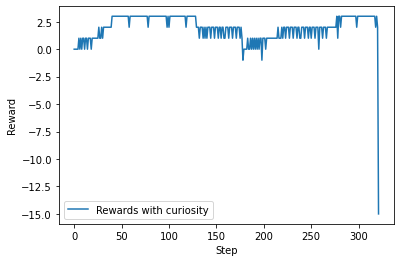

In [ ]:
plot_rewards(rewards_curiosity, 'Rewards with curiosity')

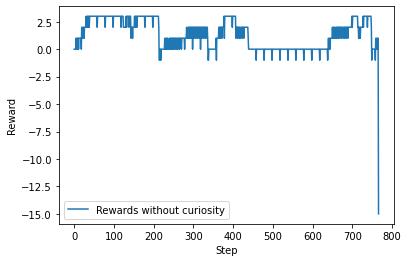

In [22]:
plot_rewards(rewards, 'Rewards without curiosity')

## Second Level

In [19]:
eval_env = gym_super_mario_bros.make('SuperMarioBros-1-2-v0')
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)

In [ ]:
# With Curiosity
rewards_curiosity, real_states_curiosity = evaluate_policy(policy_curiosity, eval_env)
print(f"Reward with Curiosity: {sum(rewards_curiosity)}")

Reward with Curiosity: 792.0


In [ ]:
create_video(real_states_curiosity, file_name="curiosity2")
show_video("curiosity2_compressed.mp4")

In [20]:
# Without Curiosity
rewards, real_states = evaluate_policy(policy, eval_env)
print(f"Reward without Curiosity: {sum(rewards)}")

Reward without Curiosity: -101.0


In [25]:
create_video(real_states, file_name="no_curiosity2")
show_video("no_curiosity2_compressed.mp4")

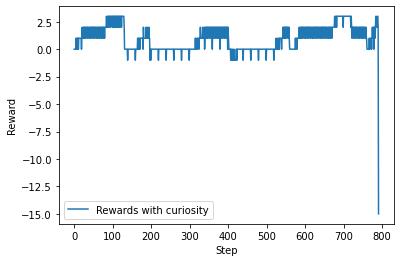

In [ ]:
plot_rewards(rewards_curiosity, 'Rewards with curiosity')

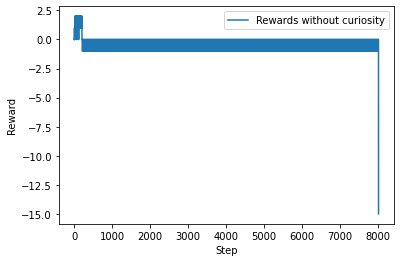

In [21]:
plot_rewards(rewards, 'Rewards without curiosity')

# Bonus :)

In [40]:
eval_env = gym_super_mario_bros.make('SuperMarioBros-2-2-v0')
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)
policy = ActorCritic(256, 7, device).to(device)
policy.load_state_dict(torch.load('/content/agents/agent.pt', map_location=device))

rewards, real_states = evaluate_policy(policy, eval_env) #no fine-tuning
print(f"Reward without Curiosity: {sum(rewards)}")

Reward without Curiosity: 1201.0


In [41]:
create_video(real_states, file_name="no_curiosity2-2")
show_video("no_curiosity2-2_compressed.mp4")

In [42]:
eval_env = gym_super_mario_bros.make('SuperMarioBros-2-3-v0')
eval_env = JoypadSpace(eval_env, SIMPLE_MOVEMENT)
policy = ActorCritic(256, 7, device).to(device)
policy.load_state_dict(torch.load('/content/agents/agent_with_curiosity.pt', map_location=device))

rewards, real_states = evaluate_policy(policy, eval_env) #no fine-tuning
print(f"Reward without Curiosity: {sum(rewards)}")

Reward without Curiosity: 1001.0


In [43]:
create_video(real_states, file_name="curiosity2-3")
show_video("curiosity2-3_compressed.mp4")

# References

Papers:

1.   [Curiosity-driven Exploration by Self-supervised Prediction](https://arxiv.org/pdf/1705.05363.pdf)
2.   [EFFICIENT PARALLEL METHODS FOR DEEP REINFORCEMENT LEARNING](https://arxiv.org/pdf/1705.04862.pdf)

Related works on curiosity-based RL in the literature:

3.   [CCLF: A Contrastive-Curiosity-Driven Learning Framework for Sample-Efficient Reinforcement Learning](https://arxiv.org/pdf/2205.00943v2.pdf)
4.   [SPATIAL GRAPH ATTENTION AND CURIOSITY-DRIVEN POLICY FOR ANTIVIRAL DRUG DISCOVERY](https://arxiv.org/pdf/2106.02190v6.pdf)
5.   [ATTENTION-BASED CURIOSITY-DRIVEN EXPLORATION IN DEEP REINFORCEMENT LEARNING](https://arxiv.org/pdf/1910.10840v1.pdf)
6. [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347.pdf)


